# LIN approximation + correction factor
## Two layer model conductivity
## Is it able to find the true conductivity?

1. We calculate all the exact solutions for all models
2. We calculate the LIN approximation solutions for the effective halfspaces

In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
from scipy.constants import mu_0

### Define the geometry of device

In [2]:
# Define Dualem-482 geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meters height From ground surface to center of coils
rad = 0.08 # Define radius of coil (8 cm)

# Source and receivers geometry

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers = [offsets-rad, offsets+rad,
              np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets, offsets*0, height]

# Frequency
freq = 9000

### Define the properties of the models of the lookup table

In [3]:
# sampling of conductivities
nsl = 81

s0 = -3 # minimum conductivity in S/m
s1 = -0.5 # maximum conductivity in S/m
# conductivities array
conds = np.logspace(s0, s1, nsl)

# Sampling of 1st layer thickness
th0 = 0.1 # minimum thickness in m
th1 = 9   # maximum thickness in m
# thickness array
thicks = np.linspace(th0, th1, nsl)


### Define forward function that provides values of quadrature for each geometry

In [4]:
def EMforward(sigma1, sigma2, thicks1):
    time.sleep(0.01)
    
    res =[2e14, 1/sigma1, 1/sigma2]
    depth=[0, thicks1]

    # Compute fields
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab=64, xdirect=None, verb=0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[2e14], freqtime=freq, ab=66, verb=0)

    Q_HCP = np.abs(np.imag(HCP_Hs/HCP_Hp))
    Q_VCP = np.abs(np.imag(VCP_Hs/VCP_Hp))
    Q_PRP = np.abs(np.imag(PRP_Hs/PRP_Hp))
    
    Q = np.hstack((Q_HCP, Q_VCP, Q_PRP))
    return Q

### Calculate the solutions for all the models

In [5]:
startTime = time.time()

Qexact = Parallel(n_jobs=-1,verbose=1)(delayed(EMforward)(sigma1, sigma2, thick1) \
                                       for sigma1 in conds for sigma2 in conds for thick1 in thicks)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 5776 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 9376 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 13776 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 18976 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 24976 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 31776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 39376 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 47776 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 56976 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 66976 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 77776 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 89376 t

Execution time in seconds: 2175.5963320732117


[Parallel(n_jobs=-1)]: Done 531441 out of 531441 | elapsed: 36.3min finished


In [6]:
# Define cummulative sensitivity functions

# z is the normalized depth with respect to coil separation (depth/coil sep)

def CS_PRP(z):
    CS = 2*z / (np.sqrt(4 * z**2 + 1))
    return CS
    
def CS_HCP(z):
    CS = 1 - 1/(np.sqrt(4 * z**2 + 1))
    return CS
    
def CS_VCP(z):
    CS = 1 - (np.sqrt(4 * z**2 + 1) - 2*z)
    return CS

def Q_from_Sigma(sigma, freq, mu_0, s):
    Q = sigma * (2 *np.pi * freq) * mu_0 * s**2 /4
    return Q

def LINforward(sigma1, sigma2, thick1):
    Q_HCP = []
    Q_VCP = []
    Q_PRP = []
    
    for coil in offsets:
        sigma_app_HCP = sigma1 * (CS_HCP(thick1/coil)) + sigma2 * (1 - CS_HCP(thick1/coil))
        sigma_app_VCP = sigma1 * (CS_VCP(thick1/coil)) + sigma2 * (1 - CS_VCP(thick1/coil))
        sigma_app_PRP = sigma1 * (CS_PRP(thick1/coil)) + sigma2 * (1 - CS_PRP(thick1/coil))
        
        Q_HCP.append(Q_from_Sigma(sigma_app_HCP, freq, mu_0, coil))
        Q_VCP.append(Q_from_Sigma(sigma_app_VCP, freq, mu_0, coil))
        Q_PRP.append(Q_from_Sigma(sigma_app_PRP, freq, mu_0, coil))
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP))

In [7]:
startTime = time.time()

QLIN = Parallel(n_jobs=-1,verbose=1)(delayed(LINforward)(sigma1, sigma2, thick1) \
                                       for sigma1 in conds for sigma2 in conds for thick1 in thicks)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 40944 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 296944 tasks      | elapsed:    9.8s


Execution time in seconds: 17.967342376708984


[Parallel(n_jobs=-1)]: Done 531441 out of 531441 | elapsed:   18.0s finished


In [8]:
# Calculate correction factors

def CalcCF(Q_exc, Q_lin):
    CF = Q_exc / Q_lin
    return CF

CF=[]
for Q_exc, Q_lin in zip(Qexact, QLIN):
    CF.append(CalcCF(Q_exc, Q_lin))

In [9]:
QLIN = np.array(QLIN)
CF = np.array(CF)

# Correction function
def corrQ(Q_ap, geom):
    if geom == 'HCP2':
        idx = (np.abs(Q_ap-QLIN[:,0])).argmin()
        return CF[idx,0]
    if geom == 'HCP4':
        idx = (np.abs(Q_ap-QLIN[:,1])).argmin()
        return CF[idx,1]
    if geom == 'HCP8':
        idx = (np.abs(Q_ap-QLIN[:,2])).argmin()
        return CF[idx,2]
    if geom == 'VCP2':
        idx = (np.abs(Q_ap-QLIN[:,3])).argmin()
        return CF[idx,3]
    if geom == 'VCP4':
        idx = (np.abs(Q_ap-QLIN[:,4])).argmin()
        return CF[idx,4]
    if geom == 'VCP8':
        idx = (np.abs(Q_ap-QLIN[:,5])).argmin()
        return CF[idx,5]
    if geom == 'PRP2':
        idx = (np.abs(Q_ap-QLIN[:,6])).argmin()
        return CF[idx,6]
    if geom == 'PRP4':
        idx = (np.abs(Q_ap-QLIN[:,7])).argmin()
        return CF[idx,7]
    if geom == 'PRP8':
        idx = (np.abs(Q_ap-QLIN[:,8])).argmin()
        return CF[idx,8]

In [10]:
def LINforwardCF(sigma1, sigma2, thick1):
    Q_HCP = []
    Q_VCP = []
    Q_PRP = []
    
    for coil in offsets:
        sigma_app_HCP = sigma1 * (CS_HCP(thick1/coil)) + sigma2 * (1 - CS_HCP(thick1/coil))
        sigma_app_VCP = sigma1 * (CS_VCP(thick1/coil)) + sigma2 * (1 - CS_VCP(thick1/coil))
        sigma_app_PRP = sigma1 * (CS_PRP(thick1/coil)) + sigma2 * (1 - CS_PRP(thick1/coil))
        
        Q_HCP_ap = Q_from_Sigma(sigma_app_HCP, freq, mu_0, coil)
        Q_VCP_ap = Q_from_Sigma(sigma_app_VCP, freq, mu_0, coil)
        Q_PRP_ap = Q_from_Sigma(sigma_app_PRP, freq, mu_0, coil)
        
        Q_HCP.append(Q_HCP_ap * corrQ(Q_HCP_ap, 'HCP'+str(coil)))
        Q_VCP.append(Q_VCP_ap * corrQ(Q_VCP_ap, 'VCP'+str(coil)))
        Q_PRP.append(Q_PRP_ap * corrQ(Q_PRP_ap, 'PRP'+str(coil)))
        
    return np.hstack((Q_HCP, Q_VCP, Q_PRP))

In [32]:
QLIN = np.array(QLIN)
CF = np.array(CF)
Qexact = np.array(Qexact)

### Check LIN forward + CF is equal to Exact solution

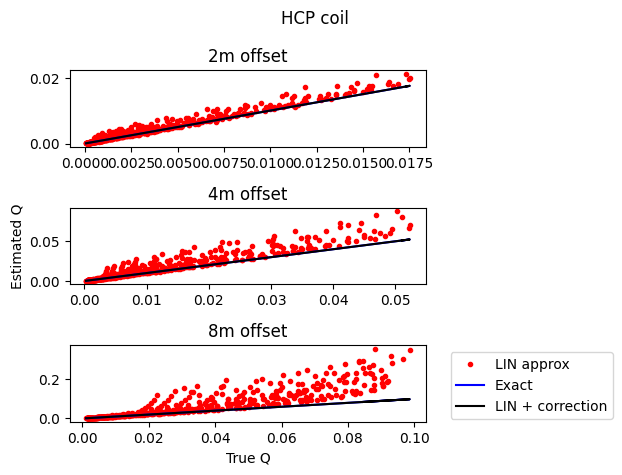

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,)

ax1.plot(Qexact[:,0][0::1000], QLIN[:,0][0::1000], '.r', label= 'LIN approx')
ax1.plot(Qexact[:,0][0::1000], Qexact[:,0][0::1000], 'b', label='Exact')
ax1.plot(Qexact[:,0][0::1000], QLIN[:,0][0::1000] * CF[:,0][0::1000], 'k', label='LIN + correction')
ax1.set_title('2m offset')

ax2.plot(Qexact[:,1][0::1000], QLIN[:,1][0::1000], '.r', label= 'LIN approx')
ax2.plot(Qexact[:,1][0::1000], Qexact[:,1][0::1000], 'b', label='Exact')
ax2.plot(Qexact[:,1][0::1000], QLIN[:,1][0::1000] * CF[:,1][0::1000], 'k', label='LIN + correction')
ax2.set_ylabel('Estimated Q')
ax2.set_title('4m offset')

ax3.plot(Qexact[:,2][0::1000], QLIN[:,2][0::1000], '.r', label= 'LIN approx')
ax3.plot(Qexact[:,2][0::1000], Qexact[:,2][0::1000], 'b', label='Exact')
ax3.plot(Qexact[:,2][0::1000], QLIN[:,2][0::1000] * CF[:,2][0::1000], 'k', label='LIN + correction')
ax3.set_xlabel('True Q')
ax3.set_title('8m offset')
ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.suptitle('HCP coil')
plt.tight_layout()

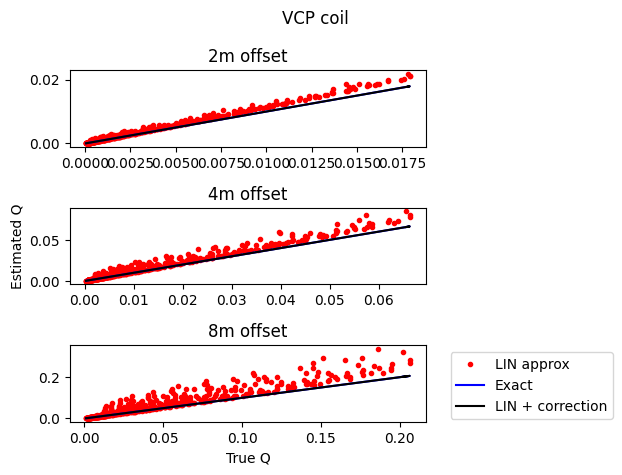

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,)

ax1.plot(Qexact[:,3][0::1000], QLIN[:,3][0::1000], '.r', label= 'LIN approx')
ax1.plot(Qexact[:,3][0::1000], Qexact[:,3][0::1000], 'b', label='Exact')
ax1.plot(Qexact[:,3][0::1000], QLIN[:,3][0::1000] * CF[:,3][0::1000], 'k', label='LIN + correction')
ax1.set_title('2m offset')

ax2.plot(Qexact[:,4][0::1000], QLIN[:,4][0::1000], '.r', label= 'LIN approx')
ax2.plot(Qexact[:,4][0::1000], Qexact[:,4][0::1000], 'b', label='Exact')
ax2.plot(Qexact[:,4][0::1000], QLIN[:,4][0::1000] * CF[:,4][0::1000], 'k', label='LIN + correction')
ax2.set_ylabel('Estimated Q')
ax2.set_title('4m offset')

ax3.plot(Qexact[:,5][0::1000], QLIN[:,5][0::1000], '.r', label= 'LIN approx')
ax3.plot(Qexact[:,5][0::1000], Qexact[:,5][0::1000], 'b', label='Exact')
ax3.plot(Qexact[:,5][0::1000], QLIN[:,5][0::1000] * CF[:,5][0::1000], 'k', label='LIN + correction')
ax3.set_xlabel('True Q')
ax3.set_title('8m offset')
ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.suptitle('VCP coil')
plt.tight_layout()

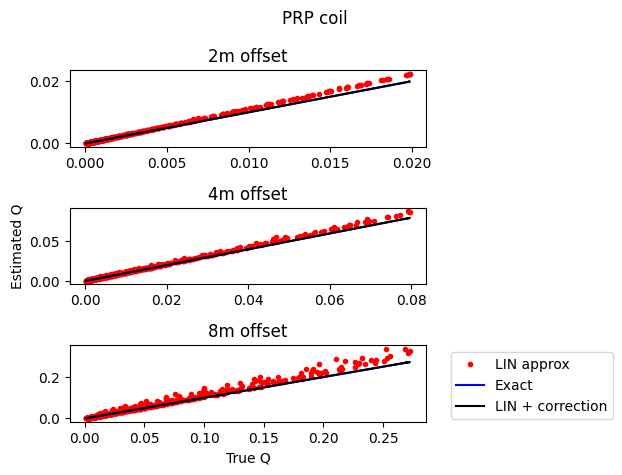

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,)

ax1.plot(Qexact[:,6][0::1000], QLIN[:,6][0::1000], '.r', label= 'LIN approx')
ax1.plot(Qexact[:,6][0::1000], Qexact[:,6][0::1000], 'b', label='Exact')
ax1.plot(Qexact[:,6][0::1000], QLIN[:,6][0::1000] * CF[:,6][0::1000], 'k', label='LIN + correction')
ax1.set_title('2m offset')

ax2.plot(Qexact[:,7][0::1000], QLIN[:,7][0::1000], '.r', label= 'LIN approx')
ax2.plot(Qexact[:,7][0::1000], Qexact[:,7][0::1000], 'b', label='Exact')
ax2.plot(Qexact[:,7][0::1000], QLIN[:,7][0::1000] * CF[:,7][0::1000], 'k', label='LIN + correction')
ax2.set_ylabel('Estimated Q')
ax2.set_title('4m offset')

ax3.plot(Qexact[:,8][0::1000], QLIN[:,8][0::1000], '.r', label= 'LIN approx')
ax3.plot(Qexact[:,8][0::1000], Qexact[:,8][0::1000], 'b', label='Exact')
ax3.plot(Qexact[:,8][0::1000], QLIN[:,8][0::1000] * CF[:,8][0::1000], 'k', label='LIN + correction')
ax3.set_xlabel('True Q')
ax3.set_title('8m offset')
ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.suptitle('PRP coil')
plt.tight_layout()

### Create a true model

In [44]:
sigma1_true = conds[25]
sigma2_true = conds[10]
thick1_true = thicks[40]

true_model=np.array([sigma1_true, sigma2_true, thick1_true])

data = LINforwardCF(sigma1_true, sigma2_true, thick1_true)

### Search model in lookup table 

In [45]:
def gridsearch(Qdata):
    err = 1
    indx=0
    for i in range(np.shape(Qexact)[0]):
        nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
        merr = np.log(np.sqrt(np.sum(nZdiff)))
        if merr < err:
            indx = i
            err = merr.copy()
   # print(nZdiff)
   # print(merr)
    return indx

In [46]:
index = gridsearch(data)

/tmp/ipykernel_219/3932827344.py:6: RuntimeWarning: divide by zero encountered in log
  merr = np.log(np.sqrt(np.sum(nZdiff)))


In [47]:
def invert(index):
    for i in range(len(conds)):
        for j in range(len(conds)):
            for k in range(len(thicks)):
                idx = k + j*nsl + i*nsl**2
                if index == idx:
                    model = np.array([conds[i], conds[j], thicks[k]])
                    return model

In [48]:
est_model=invert(index)

### Compare True and Estimated model

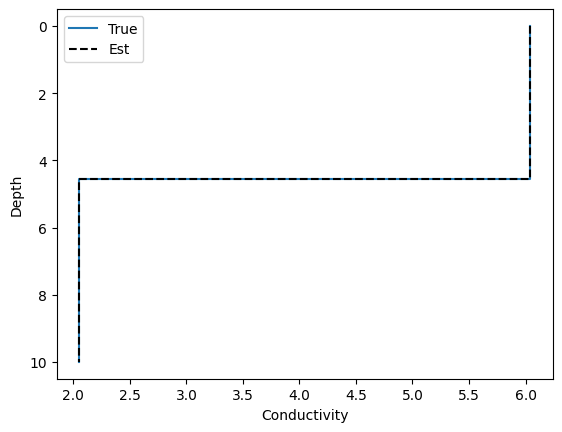

In [49]:
plt.figure()
depth_true = np.array([0, thick1_true, 10])
depth_est = np.array([0, est_model[2], 10])
sigma_true = np.array([sigma1_true, sigma2_true, sigma2_true])*1000
sigma_est = np.array([est_model[0], est_model[1], est_model[1]])*1000
plt.step(sigma_true, depth_true, label='True')
plt.step(sigma_est, depth_est, '--k' , label='Est')
plt.legend()
plt.xlabel('Conductivity')
plt.ylabel('Depth')
ax = plt.gca()
ax.invert_yaxis()

### Create a two layered 2D section with calculated solutions

In [50]:
# parameters for the synthetic model

nlayer = 2 # number of layer
npos = 20 # number of sampling positions

sig_ini = [conds[70], conds[10]]
sigmas = np.ones((npos, nlayer))*sig_ini

x = np.linspace(0, 20, npos)
thk1 = thicks[20:60:2]    # wave

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1

In [51]:
def PlotModel(sigmas, depth):
    # Arrays for plotting
    depthmax=10
    ny = 50
    y = np.linspace(0, depthmax, ny)
    sigy = np.zeros((npos, ny))

    # Conductivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            sigy[i, y1] = sigmas[i, 0]
            y1 += 1
            y2=y1
        sigy[i, y2:] = sigmas[i, 1]
    
    fig, ax = plt.subplots()
    pos = ax.imshow(sigy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], 
                    vmin = np.min(conds), vmax=np.max(conds) )
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Conductivity [S/m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')


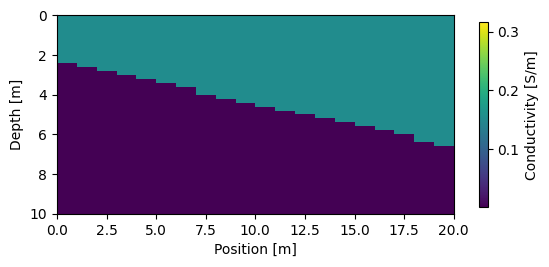

In [52]:
PlotModel(sigmas, depths)

### Calculate LIN forward + correction data for 2D section

In [53]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data=[]

for i in range(npos):
    model_i = np.hstack((sigmas[i], depths[i][1]))# True model 
    model.append(model_i)
    data.append(LINforwardCF(sigmas[i][0], sigmas[i][1], depths[i][1])) # creating data
    
# Relative error array
#error = 1e-1 # introduce here the error you want to test
#relativeError = np.ones_like(data[0]) * error

In [54]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):   
    dataE = np.array(data[i]).copy()
    #dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invert(gridsearch(dataE))
    
    model_est_list.append(model_est)

# Model estimation array  
model_est_arr = np.array(model_est_list)

/tmp/ipykernel_219/3932827344.py:6: RuntimeWarning: divide by zero encountered in log
  merr = np.log(np.sqrt(np.sum(nZdiff)))


In [55]:
sigmas_est = model_est_arr[:,0:2]
depths_est = depths.copy()
depths_est[:,1] = model_est_arr[:,2]

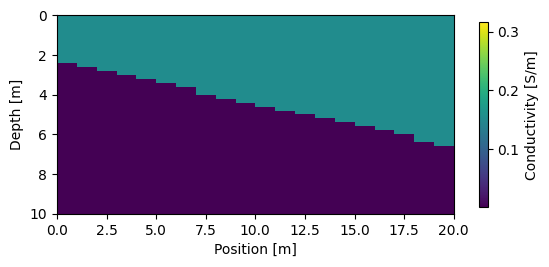

In [56]:
PlotModel(sigmas_est, depths_est)

### Are the solutions unique?

In [57]:
# Let's try with the first position

sigma1_true = model[11][0]
sigma2_true = model[11][1]
thick1_true = model[11][2]

Qdata = LINforwardCF(sigma1_true, sigma2_true, thick1_true)

err=1
merr_arr=[]
for i in range(np.shape(Qexact)[0]):
    nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
    merr = (np.log10(np.sqrt(np.sum(nZdiff))))
    merr_arr.append(np.log10(np.sqrt(np.sum(nZdiff))))
    if merr < err:
        indx = i
        err = merr.copy()
    

/tmp/ipykernel_219/4164969178.py:13: RuntimeWarning: divide by zero encountered in log10
  merr = (np.log10(np.sqrt(np.sum(nZdiff))))
/tmp/ipykernel_219/4164969178.py:14: RuntimeWarning: divide by zero encountered in log10
  merr_arr.append(np.log10(np.sqrt(np.sum(nZdiff))))


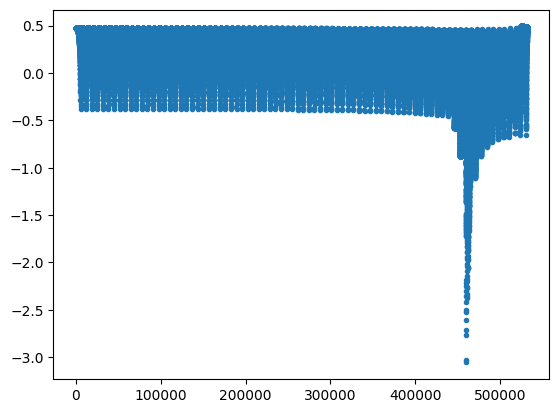

In [58]:
plt.plot(merr_arr, '.')
plt.scatter(indx, np.min(merr_arr), c='r')
plt.scatter(indx, err, c='g')

In [59]:
est_model = invert(indx)

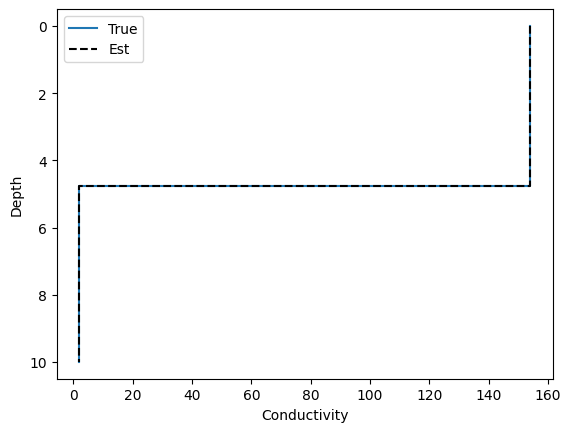

In [60]:
plt.figure()
depth_true = np.array([0, thick1_true, 10])
depth_est = np.array([0, est_model[2], 10])
sigma_true = np.array([sigma1_true, sigma2_true, sigma2_true])*1000
sigma_est = np.array([est_model[0], est_model[1], est_model[1]])*1000
plt.step(sigma_true, depth_true, label='True')
plt.step(sigma_est, depth_est, '--k' , label='Est')
plt.legend()
plt.xlabel('Conductivity')
plt.ylabel('Depth')
ax = plt.gca()
ax.invert_yaxis()

### Calculate LIN forward + correction data for 2D section

In [63]:
# parameters for the synthetic model

nlayer = 2 # number of layer
npos = 20 # number of sampling positions

sig_ini = [conds[70], conds[10]]
sigmas = np.ones((npos, nlayer))*sig_ini

x = np.linspace(0, 20, npos)
thk1 = np.ones_like(x) *2  # wave
thk1[10:] += x[10:]/5

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1

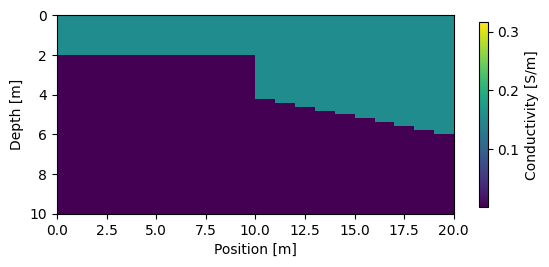

In [64]:
PlotModel(sigmas, depths)

In [65]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data=[]

for i in range(npos):
    model_i = np.hstack((sigmas[i], depths[i][1]))# True model 
    model.append(model_i)
    data.append(LINforwardCF(sigmas[i][0], sigmas[i][1], depths[i][1])) # creating data
    
# Relative error array
#error = 1e-1 # introduce here the error you want to test
#relativeError = np.ones_like(data[0]) * error

In [66]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):   
    dataE = np.array(data[i]).copy()
    #dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invert(gridsearch(dataE))
    
    model_est_list.append(model_est)

# Model estimation array  
model_est_arr = np.array(model_est_list)

In [67]:
sigmas_est = model_est_arr[:,0:2]
depths_est = depths.copy()
depths_est[:,1] = model_est_arr[:,2]

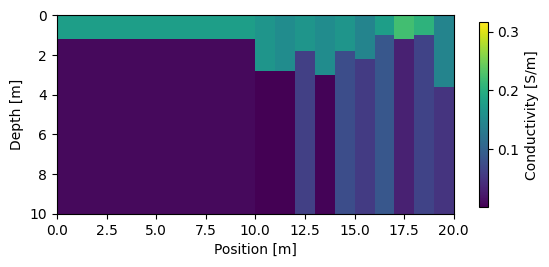

In [68]:
PlotModel(sigmas_est, depths_est)

In [69]:
# Let's try with the first position

sigma1_true = model[11][0]
sigma2_true = model[11][1]
thick1_true = model[11][2]

Qdata = LINforwardCF(sigma1_true, sigma2_true, thick1_true)

err=1
merr_arr=[]
for i in range(np.shape(Qexact)[0]):
    nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
    merr = (np.log10(np.sqrt(np.sum(nZdiff))))
    merr_arr.append(np.log10(np.sqrt(np.sum(nZdiff))))
    if merr < err:
        indx = i
        err = merr.copy()

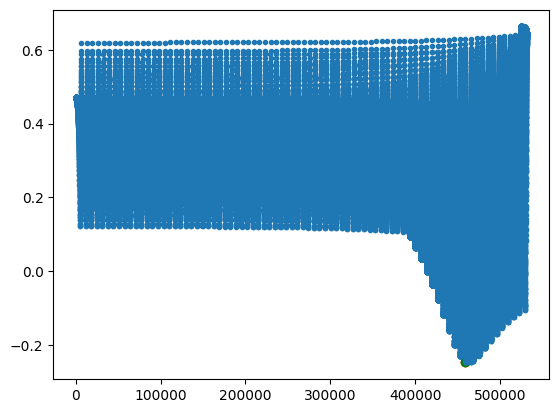

In [71]:
plt.plot(merr_arr, '.')
plt.scatter(indx, np.min(merr_arr), c='r')
plt.scatter(indx, err, c='g')

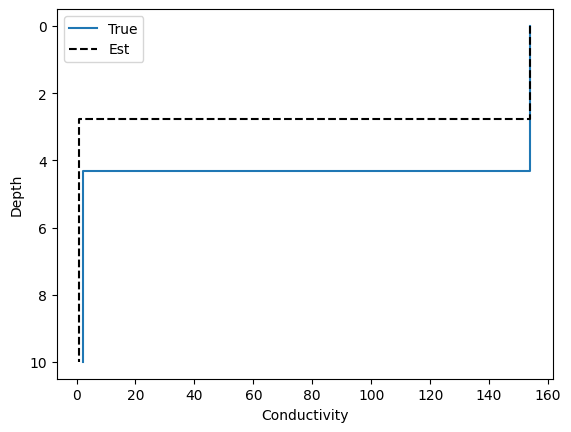

In [70]:
est_model = invert(indx)

plt.figure()
depth_true = np.array([0, thick1_true, 10])
depth_est = np.array([0, est_model[2], 10])
sigma_true = np.array([sigma1_true, sigma2_true, sigma2_true])*1000
sigma_est = np.array([est_model[0], est_model[1], est_model[1]])*1000
plt.step(sigma_true, depth_true, label='True')
plt.step(sigma_est, depth_est, '--k' , label='Est')
plt.legend()
plt.xlabel('Conductivity')
plt.ylabel('Depth')
ax = plt.gca()
ax.invert_yaxis()

In [74]:
1/sigma1_true * thick1_true + 1/sigma2_true *(10 - thick1_true)

2796.0518766213536

In [75]:
1/est_model[0] * est_model[2] + 1/est_model[1] *(10- est_model[2])

7247.987871194661